In [1]:
try:
  !pip install kaggle
except:
  pass

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 631 kB 33.0 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654017 sha256=e30f2149c30d988c4cd90cbf32636ddb3a61796d37a85a1fb53b99c69610ce8c
  Stored in directory: /root/.cache/pip/wheels/89/72/98/3ebfdba1069a9a8eaaa7ae7265cfd67d63ef0197aaee2e5f9c
Successfully built imgaug
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dineshdoddapaneni","key":"62f6f9d2ffec149e1a0d6c9687dea34a"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d sshikamaru/car-object-detection

 85% 95.0M/112M [00:05<00:01, 17.7MB/s]
100% 112M/112M [00:05<00:00, 22.4MB/s] 


In [7]:
!unzip car-object-detection.zip

Archive:  car-object-detection.zip
  inflating: data/sample_submission.csv  
  inflating: data/testing_images/vid_5_25100.jpg  
  inflating: data/testing_images/vid_5_25120.jpg  
  inflating: data/testing_images/vid_5_25140.jpg  
  inflating: data/testing_images/vid_5_25160.jpg  
  inflating: data/testing_images/vid_5_25180.jpg  
  inflating: data/testing_images/vid_5_25200.jpg  
  inflating: data/testing_images/vid_5_25220.jpg  
  inflating: data/testing_images/vid_5_25240.jpg  
  inflating: data/testing_images/vid_5_25260.jpg  
  inflating: data/testing_images/vid_5_26320.jpg  
  inflating: data/testing_images/vid_5_26400.jpg  
  inflating: data/testing_images/vid_5_26420.jpg  
  inflating: data/testing_images/vid_5_26560.jpg  
  inflating: data/testing_images/vid_5_26580.jpg  
  inflating: data/testing_images/vid_5_26600.jpg  
  inflating: data/testing_images/vid_5_26620.jpg  
  inflating: data/testing_images/vid_5_26640.jpg  
  inflating: data/testing_images/vid_5_26660.jpg  
  inf

In [8]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from albumentations.pytorch.transforms import ToTensor
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.rpn import AnchorGenerator
from PIL import Image

In [9]:
import albumentations as A

In [10]:
da=pd.read_csv('/content/data/train_solution_bounding_boxes (1).csv')

In [11]:
da.head()

image        xmin        ymin        xmax        ymax
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2  vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3  vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422

['vid_4_10040.jpg' 239.1924747 176.7648005 361.9681621 236.4301802]


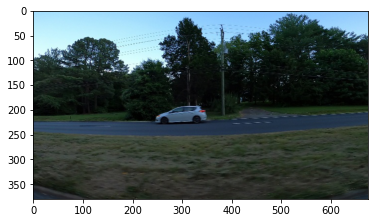

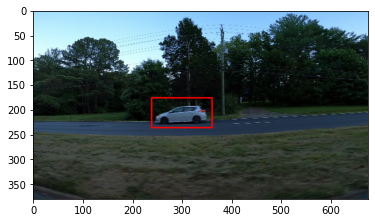

In [12]:
for i in da.values[2:]:
  print(i)
  p=plt.imread('/content/data/training_images/'+i[0])
  plt.imshow(p)
  p1=(int(i[1]),int(i[2]))
  p2=(int(i[3]),int(i[4]))
  cv2.rectangle(p,p1,p2,(255,0,0),2)
  plt.figure()
  plt.imshow(p)
  break

In [13]:
ids=da['image'].unique()

In [14]:
class dfg():
  def __init__(self, df, image_dir, transforms=None):
      super().__init__()
      self.image_ids = df["image"].unique() 
      self.df = df
      self.image_dir = image_dir 
      self.transforms = transforms

  def __getitem__(self, idx: int):
      image_id = self.image_ids[idx]
      records = self.df[self.df["image"] == image_id]
      image = cv2.imread(f"{self.image_dir}/{image_id}", cv2.IMREAD_COLOR)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
      image /= 255.0
      image = torch.tensor(image)
      image = image.permute(2,0,1)
      boxes = records[["xmin", "ymin", "xmax", "ymax"]].values
      boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
      boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
      area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
      area = torch.as_tensor(area, dtype=torch.float32)
      labels = torch.ones((records.shape[0]), dtype=torch.int64)
      target = {}
      target["boxes"] = torch.tensor(boxes)
      target["labels"] = labels
      target["image_id"] = torch.tensor([idx])
      target["area"] = area


      if self.transforms:
          sample = {"image": image, "boxes": target["boxes"], "labels": labels}
          sample = self.transforms(**sample)
          image = sample["image"]
          target["boxes"] = torch.stack(tuple(map(torch.tensor, zip(*sample["boxes"])))).permute(1, 0)

      return image, target, image_id

  def __len__(self):
      return self.image_ids.shape[0]

In [15]:
def gtt():
    return A.Compose([
        A.Flip(0.5),
        ToTensor(p=1.0)
    ], bbox_params={"format": "pascal_voc", "label_fields": ["labels"]})

In [16]:
m=fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [17]:
nc=2
inf=m.roi_heads.box_predictor.cls_score.in_features
m.roi_heads.box_predictor=FastRCNNPredictor(inf,nc)

In [18]:
from pandas.core.dtypes.dtypes import PandasExtensionDtype
def collate_fn(batch):
    return tuple(zip(*batch))

trd=pd.read_csv("/content/data/train_solution_bounding_boxes (1).csv")
patht="/content/data/training_images"
tds=dfg(trd,patht)


In [19]:
train_dl = DataLoader(tds,batch_size=8,shuffle=False,num_workers=4,collate_fn=collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [20]:
dev=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [21]:
img,tar,iid=next(iter(train_dl))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [22]:
m.to(dev)
params =[p for p in m.parameters() if p.requires_grad]
optimizer=torch.optim.Adam(params, lr=0.0005, weight_decay=0.0005)

In [23]:
itr=1
m.train()
for epoch in range(3):   
    for images, targets, image_ids in train_dl:
        images = list(image.to(dev) for image in images)
        targets = [{k: v.to(dev) for k, v in t.items()} for t in targets]
        loss_dict=m(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        print(f"Iteration #{itr} loss: {loss_value}")
        itr += 1
        

print('training over')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Iteration #1 loss: 0.7678623360302272
Iteration #2 loss: 0.13280251712059374
Iteration #3 loss: 0.249737922001948
Iteration #4 loss: 0.11948317329762902
Iteration #5 loss: 0.10263037441565913
Iteration #6 loss: 0.21042553539914072
Iteration #7 loss: 0.3407264852236624
Iteration #8 loss: 0.31979888179204824
Iteration #9 loss: 0.11407510090218412
Iteration #10 loss: 0.16702871723291685
Iteration #11 loss: 0.05776631828803694
Iteration #12 loss: 0.08319308822767572
Iteration #13 loss: 0.07662051230211059
Iteration #14 loss: 0.07187400249520408
Iteration #15 loss: 0.14452807080300667
Iteration #16 loss: 0.13818532001870276
Iteration #17 loss: 0.10247350690764125
Iteration #18 loss: 0.08458242861007681
Iteration #19 loss: 0.07737048909637002
Iteration #20 loss: 0.28322756638158975
Iteration #21 loss: 0.11550874849732168
Iteration #22 loss: 0.09691891690745252
Iteration #23 loss: 0.08536593204215166
Iteration #24 loss: 0.09899073552564591
Iteration #25 loss: 0.06184288710132013
Iteration #26

NameError: ignored

In [27]:
torch.save(m,'model.pt')

In [53]:
imt=cv2.imread('/content/data/testing_images/vid_5_26580.jpg',cv2.IMREAD_COLOR)
imt=cv2.cvtColor(imt, cv2.COLOR_BGR2RGB).astype(np.float32)
imt/=255.0
s=imt
imt=torch.tensor(imt)
images=imt.permute(2,0,1)
images= torch.unsqueeze(images, 0)
images=images.to(dev)
m.eval()
cpu_device=torch.device("cpu")
op=m(images)
op=[{k: v.to(cpu_device) for k, v in t.items()} for t in op]
boxes=op[0]["boxes"].detach().numpy().astype(np.int32)
#print(op)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

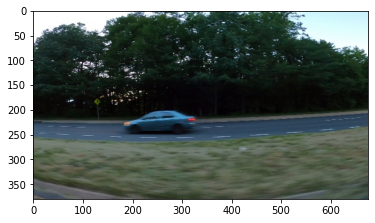

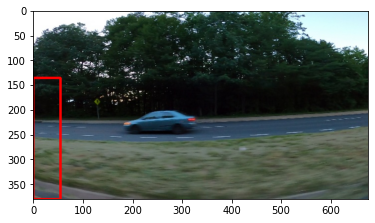

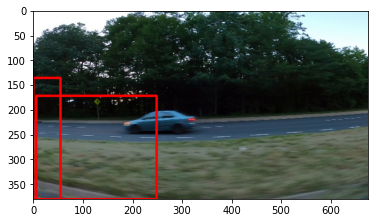

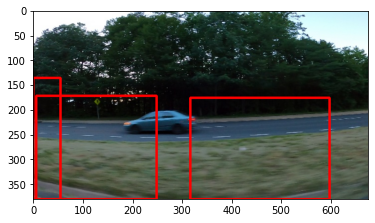

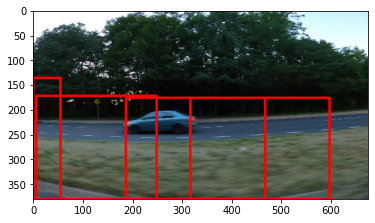

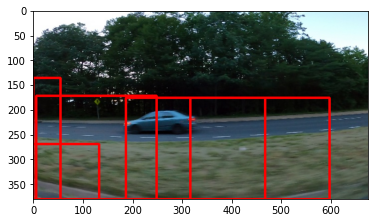

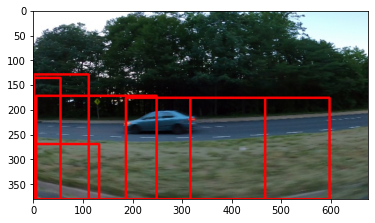

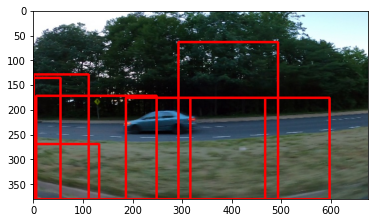

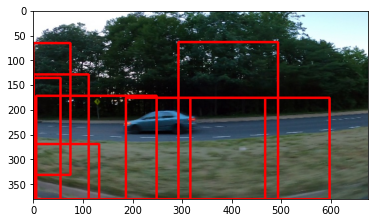

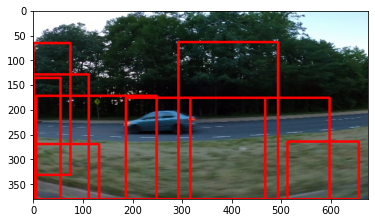

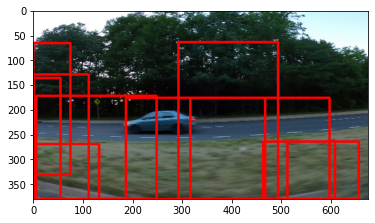

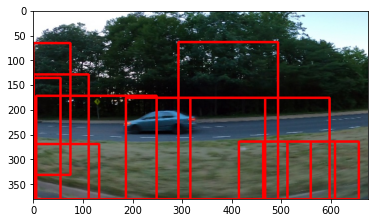

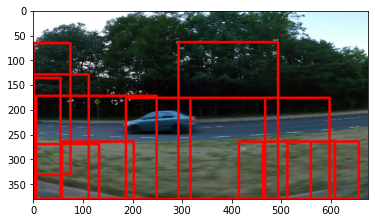

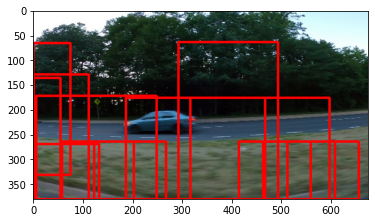

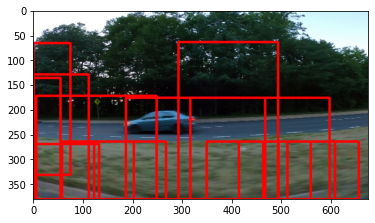

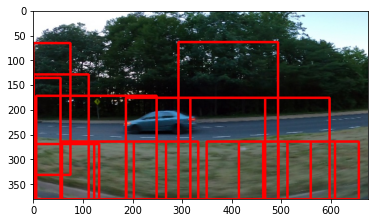

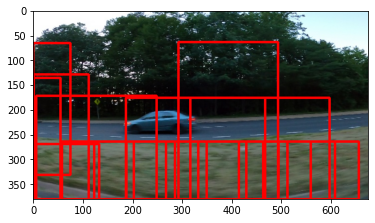

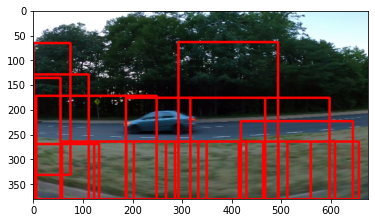

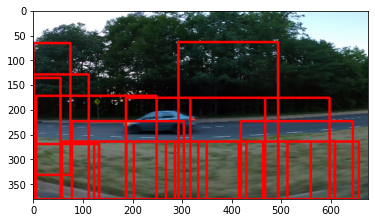

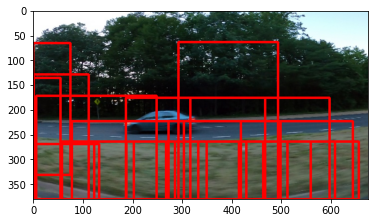

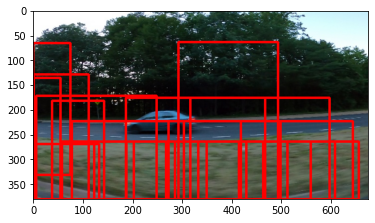

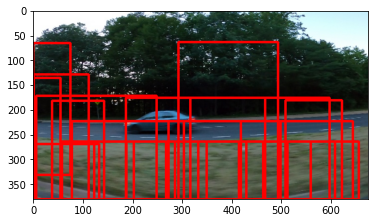

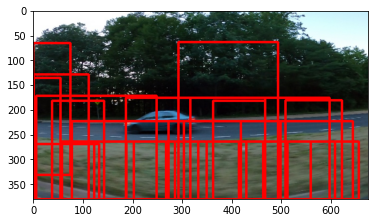

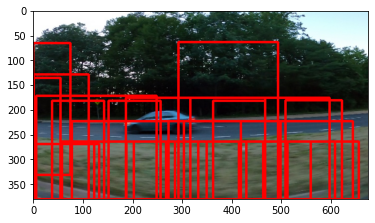

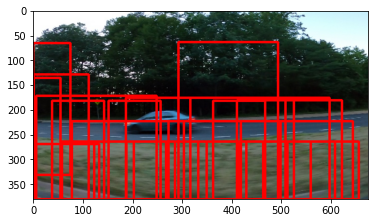

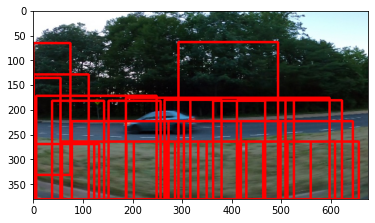

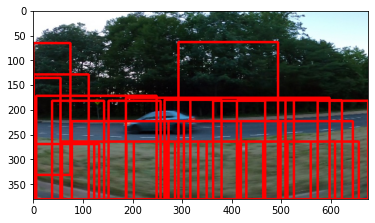

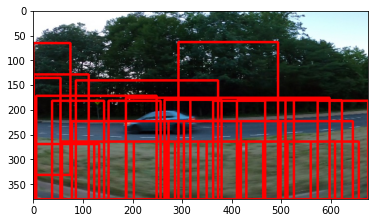

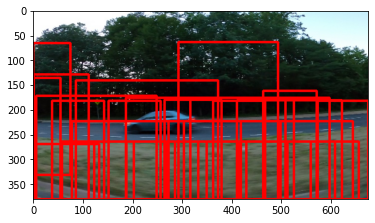

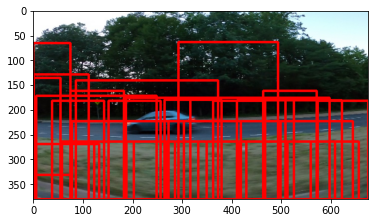

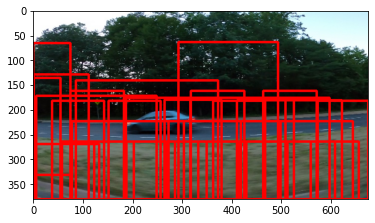

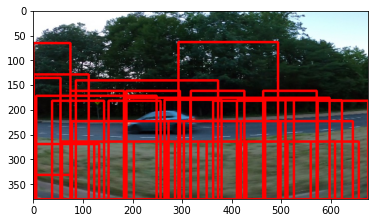

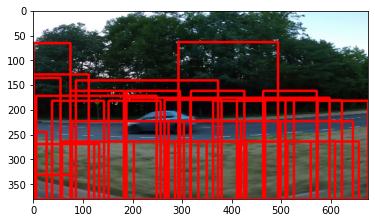

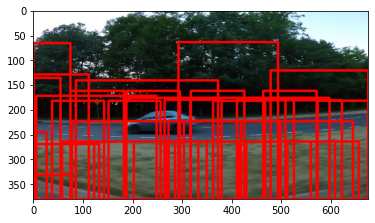

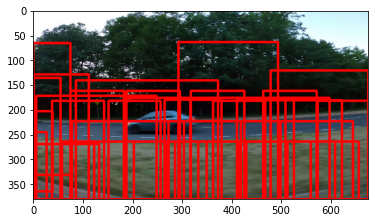

<Figure size 432x288 with 0 Axes>

In [52]:
plt.imshow(s)
plt.figure()
for i in boxes:
   cv2.rectangle(s,
                  (i[0], i[1]),
                  (i[2], i[3]),
                  (220, 0, 0), 3)
plt.imshow(s)
#   plt.figure()

In [43]:
def ins(a,b,c,d):
  

[[  0 202  77 380]
 [  9 174 356 380]
 [306 173 676 380]
 [112 173 520 380]
 [  0 269 133 380]
 [  0  12  84 380]
 [  2 120 185 380]
 [  0 111  55 371]
 [260  44 462 380]
 [ 97  44 299 380]
 [123 264 268 380]
 [ 58 264 203 380]
 [188 264 333 380]
 [302 264 446 380]
 [367 264 511 380]
 [432 264 576 380]
 [497 264 641 380]
 [ 29 223 256 380]
 [110 223 337 380]
 [208 223 434 380]
 [354 223 580 380]
 [550 248 676 380]
 [  0  14  76 207]
 [233 182 338 380]
 [412 182 517 380]
 [103 181 217 380]
 [ 38 180 153 380]
 [168 180 282 380]
 [346 180 461 380]
 [282 180 396 380]
 [493 180 607 380]
 [448 162 556 380]
 [155 121 351 380]
 [317 120 513 380]
 [447 120 643 380]
 [  0 263  40 380]]
